Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [2]:
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Importing Data

In [3]:
# Custom class to flatten the tensor while loading dataset.
class tensorFlatten():
  def __init__(self, start_dim, end_dim):
    self.start_dim = start_dim
    self.end_dim = end_dim

  def __call__(self, tensor):
    flattened_tensor = torch.flatten(tensor, start_dim = self.start_dim, end_dim = self.end_dim)
    return flattened_tensor

  def __repr__(self):
    repr = f"{self.__class__.__name__  }(start_dim={self.start_dim}, end_dim={self.end_dim})"

In [4]:
# Importing Data
mnist_train = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               #torchvision.transforms.Normalize(
                                 #(0.1307,), (0.3081,)),
                                 tensorFlatten(0,-1),
                             ]))

mnist_test = torchvision.datasets.MNIST('mnist', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               #torchvision.transforms.Normalize(
                                 #(0.1307,), (0.3081,)),
                                 tensorFlatten(0,-1),
                             ]))


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw
Processing...
Done!




/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...
Done!


In [5]:
# Defining train and test loaders to load the data
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, drop_last = True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size = batch_size, drop_last = True)

In [6]:
#Learning parameters
learning_param = .001
epochs = 5

# network_parameters
input_shape = 784
hidden_nodes = 512

# Change this value for latent space effect on visualisation of reconstructed_data.
latent_dim = 2

# Loss to be used
loss_type = F.binary_cross_entropy

## • Defining Neural Network Architecture

In [7]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE,self).__init__()
    
    self.hidden_layer1 = nn.Linear(in_features = input_shape, out_features = hidden_nodes)
    self.hidden_layer21 = nn.Linear(in_features = hidden_nodes, out_features = latent_dim)
    self.hidden_layer22 = nn.Linear(in_features = hidden_nodes, out_features = latent_dim)
    
    self.hidden_layer3 = nn.Linear(in_features = latent_dim, out_features = hidden_nodes)
    self.hidden_layer4 = nn.Linear(in_features = hidden_nodes, out_features = input_shape)

  def encode(self, x):
    x = x.to(device)
    x = F.relu(self.hidden_layer1(x))

    mu = self.hidden_layer21(x)
    logvar = self.hidden_layer22(x)
    return mu,logvar

  def reparametrize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

  def decode(self, x):
    x = F.relu(self.hidden_layer3(x))
    # If using binary cross entropy loss
    output = torch.sigmoid(self.hidden_layer4(x))

    # If using MSE loss
    # output = self.hidden_layer4(x)
    return output

  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparametrize(mu, logvar)
    output = self.decode(z)
    return output, mu, logvar
      

## • Defining Loss Function

In [8]:
def lossFunction(recons_x, x, mu, logvar, loss_type):
  recons_loss = F.binary_cross_entropy(recons_x+1e-8, x, reduction='sum')
  

  # -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  #print(recons_loss, KLD)
  return recons_loss + KLD

## • Defining Training Loop

In [9]:
# This snippet is used to actually train the network.
def training_loop(network, optimizer, epochs, train_loader, test_loader):

  for epoch in range(epochs):

    train_loss = 0
    batch_idx = 0
    #print(f'start of epoch {epoch}---------------------------------->')
    for batch in train_loader:
      training_sample, _ = batch
      training_sample = training_sample.to(device)

      recons_output, mu, logvar = network(training_sample)
      #print(recons_output[0])
      loss = lossFunction(recons_output, training_sample , mu, logvar, loss_type)
      train_loss+=loss
      optimizer.zero_grad()

      loss.backward()
      optimizer.step()
      
      #print(f'loss for batch {batch_idx} = {loss}')
      batch_idx+=1
    #print(train_loss)
    print(f'epoch {epoch} completed. Avg training_loss = {train_loss.item()/len(train_loader.dataset)}')
  
  print("Finished network training")

## • Training using BCE as recostruction Loss

In [27]:
network = VAE().to(device)
optimizer = optim.Adam(network.parameters(),lr = .001)
training_loop(network, optimizer, epochs, train_loader, test_loader)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 0 completed. Avg training_loss = 174.36573333333334
epoch 1 completed. Avg training_loss = 163.12898333333334
epoch 2 completed. Avg training_loss = 160.03358333333333
epoch 3 completed. Avg training_loss = 157.87446666666668
epoch 4 completed. Avg training_loss = 156.25543333333334
Finished network training


## • Defining Generating Loop

In [10]:
def generateSamples(network, latent_variable):
  with torch.no_grad():
    output = network.decode(latent_variable)
  return output


## • Visualisation 

### 1) Visualisating 2 dimensional Latent space

<b> Writing Plotting Functions</b>

In [11]:
def visualisation(samples, n):
  grid = torchvision.utils.make_grid(samples.view(-1,1, 28,28), nrow=n)
  print(grid.shape)
  return grid
  #plt.figure(figsize = (10,10))
  #plt.imshow(np.transpose(grid, (1,2,0)))

def plotGraphs(grids, titles):
  plt.figure(1, figsize=(10,5))

  plt.subplot(121)
  plt.imshow(np.transpose(grids[0], (1,2,0)))
  plt.xlabel('X axis of hidden space')
  plt.ylabel('Y axis of hidden space')
  plt.title(titles[0])

  plt.subplot(122)
  plt.imshow(np.transpose(grids[1], (1,2,0)))
  plt.xlabel('X axis of hidden space')
  plt.ylabel('Y axis of hidden space')
  plt.title(titles[1])

  plt.show()

<b> Generating latent space data using 2 ways(continuous, random)</b>

In [ ]:
# Creating a grid of points in 2 dimensional space.
n= 20
x_limit = np.linspace(-2,2,n)
y_limit = np.linspace(2,-2,n)

latent_space = torch.from_numpy(np.zeros((n*n,latent_dim), dtype = np.float32))
batch_idx = 0
for i in range(len(y_limit)):
  for j in range(len(x_limit)):
    latent_space[batch_idx] = torch.tensor([x_limit[j],y_limit[i]], dtype = torch.float32)
    batch_idx+=1

latent_space.to(device)
new_samples = generateSamples(network, latent_space)

grid1 = visualisation(new_samples, n)
title1 = 'Continuous manifold in hidden space'

In [ ]:
# Generating random points in 2 dimensional space using Gaussian Distibution
latent_space = torch.randn((n*n,2), dtype = torch.float32)
latent_space.to(device)
new_samples = generateSamples(network, latent_space)

grid2 = visualisation(new_samples, n)
title2 = 'Random samples from normal distribution'

<b>Plotting Graphs</b>

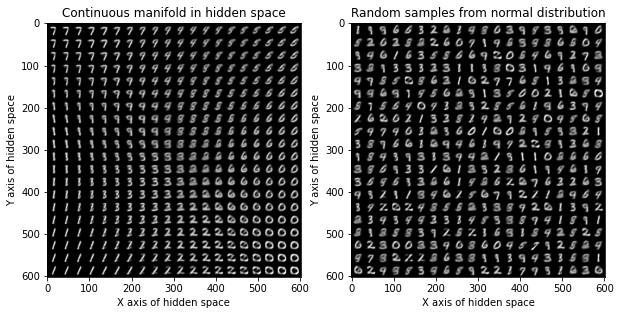

In [152]:
grids = [grid1,grid2]
titles = [title1, title2]
plotGraphs(grids,titles)

### 2) Visualisation with different latent space dimensions

<b> Writing Plotting Functions</b>

In [171]:
def visualisation(samples, n):
  grid = torchvision.utils.make_grid(samples.view(-1,1, 28,28), nrow=n)
  print(grid.shape)
  return grid
  #plt.figure(figsize = (10,10))
  #plt.imshow(np.transpose(grid, (1,2,0)))

def plotGraphsLatentVariation(grids, titles):
  plt.figure(1, figsize=(20,15))

  plt.subplot(131)
  plt.imshow(np.transpose(grids[0], (1,2,0)))
  plt.xlabel('X axis of hidden space')
  plt.ylabel('Y axis of hidden space')
  plt.title(titles[0])

  plt.subplot(132)
  plt.imshow(np.transpose(grids[1], (1,2,0)))
  plt.xlabel('X axis of hidden space')
  plt.ylabel('Y axis of hidden space')
  plt.title(titles[1])

  plt.subplot(133)
  plt.imshow(np.transpose(grids[2], (1,2,0)))
  plt.xlabel('X axis of hidden space')
  plt.ylabel('Y axis of hidden space')
  plt.title(titles[2])

  plt.show()

<b> Training 3 networks for different hidden space dimensionality(2,10,20)</b>

In [ ]:
latent_dim = 2
network1 = VAE().to(device)
optimizer = optim.Adam(network1.parameters(),lr = .001)
training_loop(network1, optimizer, epochs, train_loader, test_loader)

In [ ]:
latent_dim = 10
network2 = VAE().to(device)
optimizer = optim.Adam(network2.parameters(), lr=.001)
training_loop(network2, optimizer, epochs, train_loader, test_loader)

In [ ]:
latent_dim = 20
network3 = VAE().to(device)
optimizer = optim.Adam(network3.parameters(), lr=.001)
training_loop(network3, optimizer, epochs, train_loader, test_loader)

<b> Generating new samples</b>


In [165]:
n = 20

latent_space = torch.randn((n*n,2), dtype = torch.float32)
latent_space.to(device)
new_samples = generateSamples(network1, latent_space)
grid1 = visualisation(new_samples, n)
title1 = 'Hidden dimension=2'

latent_space = torch.randn((n*n,10), dtype = torch.float32)
latent_space.to(device)
new_samples = generateSamples(network2, latent_space)
grid2 = visualisation(new_samples, n)
title2 = 'Hidden dimension=10'

latent_space = torch.randn((n*n,20), dtype = torch.float32)
latent_space.to(device)
new_samples = generateSamples(network3, latent_space)
grid3 = visualisation(new_samples, n)
title3 = 'Hidden dimension=20'

torch.Size([3, 602, 602])
torch.Size([3, 602, 602])
torch.Size([3, 602, 602])


<b>Plotting</b>

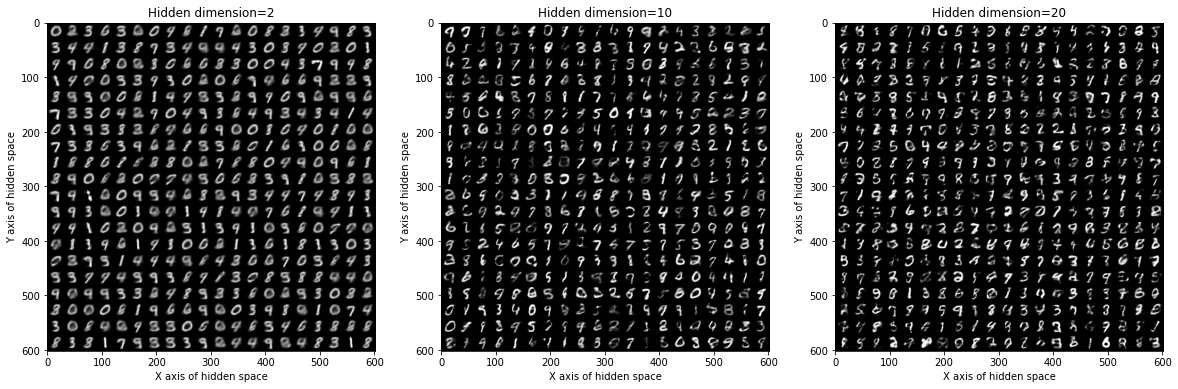

In [172]:
grids = [grid1, grid2, grid3]
titles = [title1, title2, title3]
plotGraphsLatentVariation(grids, titles)

### 3)Visualisation with respect to terms in the loss function.


<b> Writing Plotting Functions</b>

In [64]:
def visualisation(samples, n):
  grid = torchvision.utils.make_grid(samples.view(-1,1, 28,28), nrow=n)
  print(grid.shape)
  return grid
  #plt.figure(figsize = (10,10))
  #plt.imshow(np.transpose(grid, (1,2,0)))


def plotGraphsLossVariation(grids, titles, test_labels):
  plt.figure(1, figsize=(20,15))
  colors = test_labels

  plt.subplot(331)
  plt.imshow(np.transpose(grids[0][0], (1,2,0)))
  plt.xlabel('X axis of hidden space')
  plt.ylabel('Y axis of hidden space')
  plt.title(titles[0][0])

  plt.subplot(332)
  plt.imshow(np.transpose(grids[0][1], (1,2,0)))
  plt.xlabel('X axis of hidden space')
  plt.ylabel('Y axis of hidden space')
  plt.title(titles[0][1])

  plt.subplot(333)
  plt.scatter(grids[0][2][:,0], grids[0][2][:,1], c=colors, cmap='viridis' )
  plt.xlabel('X axis of hidden space')
  plt.ylabel('Y axis of hidden space')
  plt.title(titles[0][2])

  plt.subplot(334)
  plt.imshow(np.transpose(grids[1][0], (1,2,0)))
  plt.xlabel('X axis of hidden space')
  plt.ylabel('Y axis of hidden space')
  plt.title(titles[1][0])

  plt.subplot(335)
  plt.imshow(np.transpose(grids[1][1], (1,2,0)))
  plt.xlabel('X axis of hidden space')
  plt.ylabel('Y axis of hidden space')
  plt.title(titles[1][1])

  plt.subplot(336)
  plt.scatter(grids[1][2][:,0], grids[1][2][:,1], c=colors, cmap='viridis' )
  plt.xlabel('X axis of hidden space')
  plt.ylabel('Y axis of hidden space')
  plt.title(titles[1][2])

  plt.subplot(337)
  plt.imshow(np.transpose(grids[2][0], (1,2,0)))
  plt.xlabel('X axis of hidden space')
  plt.ylabel('Y axis of hidden space')
  plt.title(titles[2][0])

  plt.subplot(338)
  plt.imshow(np.transpose(grids[2][1], (1,2,0)))
  plt.xlabel('X axis of hidden space')
  plt.ylabel('Y axis of hidden space')
  plt.title(titles[2][1])

  plt.subplot(339)
  plt.scatter(grids[2][2][:,0], grids[2][2][:,1], c=colors, cmap='viridis' )
  plt.xlabel('X axis of hidden space')
  plt.ylabel('Y axis of hidden space')
  plt.title(titles[2][2])

  plt.show()

<b> Defining Loss which takes into account different values of alpha and beta</b>

In [12]:
def lossFunction(recons_x, x, mu, logvar, loss_type, alpha, beta):
  recons_loss = F.binary_cross_entropy(recons_x+1e-8, x, reduction='sum')
  

  # -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  #print(recons_loss, KLD)
  return alpha*recons_loss + beta*KLD

<b> Writing Updated Training Loop</b>

In [13]:
# This snippet is used to actually train the network.
def training_loop(network, optimizer, epochs, train_loader, test_loader, alpha, beta):

  for epoch in range(epochs):

    train_loss = 0
    batch_idx = 0
    #print(f'start of epoch {epoch}---------------------------------->')
    for batch in train_loader:
      training_sample, _ = batch
      training_sample = training_sample.to(device)

      recons_output, mu, logvar = network(training_sample)
      #print(recons_output[0])
      loss = lossFunction(recons_output, training_sample , mu, logvar, loss_type, alpha, beta)
      train_loss+=loss
      optimizer.zero_grad()

      loss.backward()
      optimizer.step()
      
      #print(f'loss for batch {batch_idx} = {loss}')
      batch_idx+=1
    #print(train_loss)
    print(f'epoch {epoch} completed. Avg training_loss = {train_loss.item()/len(train_loader.dataset)}')
  
  print("Finished network training")

<b> Training 3 networks with different values of alpha and beta</b>

In [ ]:
# Cosidering only reconstruction loss
# alpha = 1, beta = 0
latent_dim = 2
alpha = 1
beta = 0
epochs = 10

network1 = VAE().to(device)
optimizer = optim.Adam(network1.parameters(), lr = .001)
training_loop(network1, optimizer, epochs, train_loader, test_loader, alpha, beta)

In [ ]:
latent_dim = 2
alpha = 0
beta = 1

network2 = VAE().to(device)
optimizer = optim.Adam(network2.parameters(), lr = .001)
training_loop(network2, optimizer, epochs, train_loader, test_loader, alpha, beta)

In [ ]:
latent_dim = 2
alpha = 1
beta = 1

network3 = VAE().to(device)
optimizer = optim.Adam(network3.parameters(), lr = .001)
training_loop(network3, optimizer, epochs, train_loader, test_loader, alpha, beta)

<b> Generating latent space data using 2 ways(continuous, random)</b>

In [ ]:
n = 20

latent_space = torch.randn((n*n,2), dtype = torch.float32).to(device)
#latent_space = latent_space.to(device)

new_samples1b = generateSamples(network1, latent_space)
grid1b = visualisation(new_samples1b,n)
title1b = 'Considering only Reconstruction Loss (alpha=1, beta=0)'

new_samples2b = generateSamples(network2, latent_space)
grid2b = visualisation(new_samples2b,n)
title2b = 'Considering only KLD (alpha=0, beta=1)'

new_samples3b = generateSamples(network3, latent_space)
grid3b = visualisation(new_samples3b, n)
title3b = 'Considering both terms (alpha=1, beta=1)'

In [ ]:
n= 20
x_limit = np.linspace(-2,2,n)
y_limit = np.linspace(2,-2,n)

latent_space = torch.from_numpy(np.zeros((n*n,latent_dim), dtype = np.float32))
batch_idx = 0
for i in range(len(y_limit)):
  for j in range(len(x_limit)):
    latent_space[batch_idx] = torch.tensor([x_limit[j],y_limit[i]], dtype = torch.float32)
    batch_idx+=1

latent_space = latent_space.to(device)


new_samples1a = generateSamples(network1, latent_space)
grid1a = visualisation(new_samples1a, n)
title1a = 'Hidden dimension=2'

new_samples2a = generateSamples(network2, latent_space)
grid2a = visualisation(new_samples2a, n)
title2a = 'Hidden dimension=2'

new_samples3a = generateSamples(network3, latent_space)
grid3a = visualisation(new_samples3a, n)
title3a = 'Hidden dimension=2'



<b> Finding hidden representation for test data for visualisation</b>

In [62]:
batch_size = 10000
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size)
test_samples,test_labels = next(iter(test_loader))

test_samples = test_samples.to(device)
test_labels = test_labels.to(device)

with torch.no_grad():
  mu,logvar = network1.encode(test_samples)
  hidden_representation1 = network1.reparametrize(mu,logvar)
  
  mu, logvar =network2.encode(test_samples)
  hidden_representation2 = network2.reparametrize(mu,logvar)

  mu, logvar = network3.encode(test_samples)
  hidden_representation3 = network3.reparametrize(mu,logvar)

title1c = 'Test sample Embedding'
title2c = 'Test sample Embedding'
title3c = 'Test sample Embedding'


<b>Plotting</b>

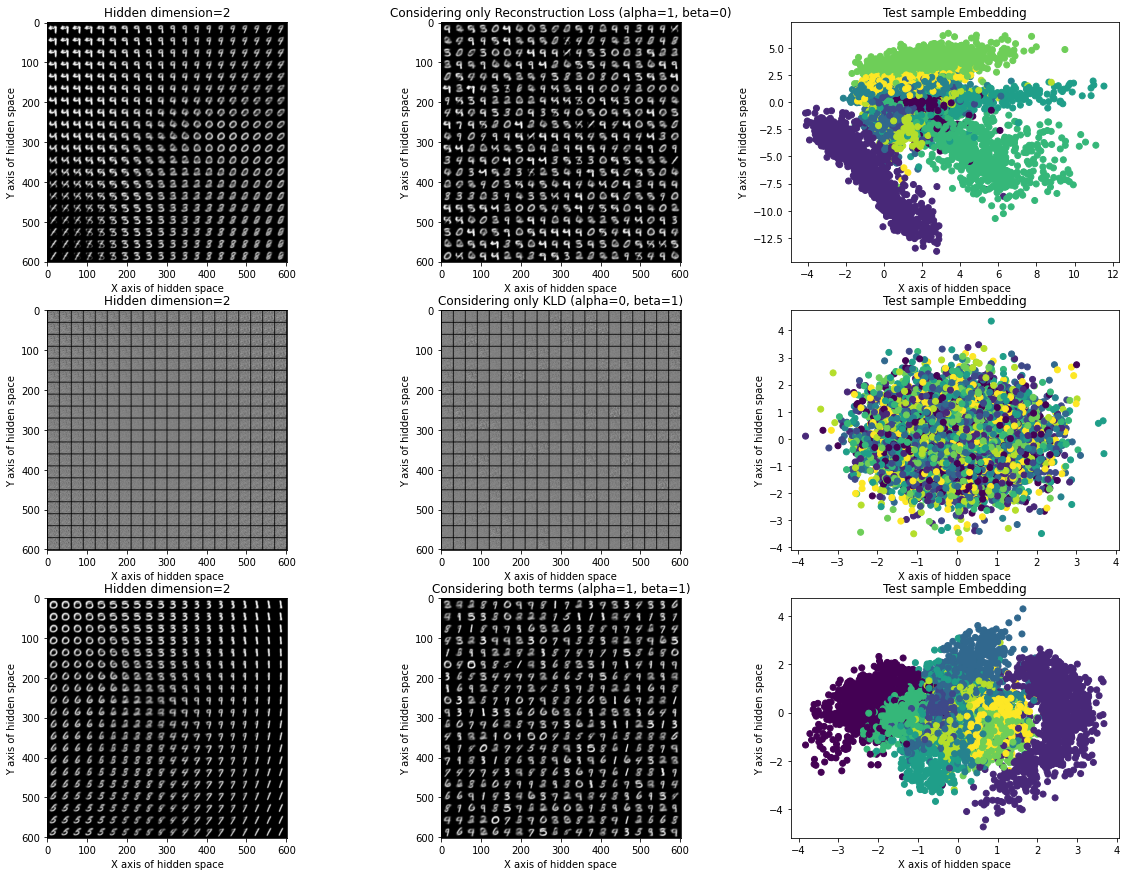

In [65]:
grids = [[grid1a.cpu(), grid1b.cpu(),hidden_representation1.cpu()], [grid2a.cpu(),grid2b.cpu(),hidden_representation2.cpu()], [grid3a.cpu(),grid3b.cpu(),hidden_representation3.cpu()]]
titles = [[title1a,title1b,title1c], [title2a,title2b,title2c], [title3a,title3b,title3c]]
plotGraphsLossVariation(grids, titles, test_labels.cpu())